In [ ]:
%cd ..

In [8]:
#pip install matplotlib numpy pandas seaborn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.pyplot import figure
import seaborn as sns
import random
import sys
from itertools import combinations
import scipy.cluster.hierarchy as shc
from Bio.pairwise2 import format_alignment
from src import dataset_simulator
import networkx as nx



In [8]:
# mutate seq
def mutate_seq(seq, alphabets='ACTG'):
    L = len(seq)
    i = random.randint(0, L-1) # position to mutate
    x = seq[i] #init
    while x == seq[i]: # check if different 
        x = random.choices(alphabets,k=1)[0] # apply mutation if not
    seq = seq[:i] + x + seq[i+1:] # insert new mutated base in sequence
    return seq


In [223]:
## Binary tree
### N generations
id = "D1"
L = 100 # len of sequence
mutation_rate = 0.01
generations = 5 # N = g!
random_sequence = dataset_simulator.generate_random_seq(L) #sequence of lenght L

# make binary dataset 
simulated_dataset = dataset_simulator.make_binray_tree(random_sequence, generations = generations, mutation_rate = mutation_rate, mutation_types='S')

dataset_simulator.dict_to_fasta(simulated_dataset , './data/simulation_dataset/' , filename = id)


In [224]:

from Bio import pairwise2
from Bio import Align

# 1. pairwise align
id = "D1"
path = './data/tmp/'

simulated_dataset = {}
f = open('./data/simulation_dataset/' + id + '.fasta', 'r').read().split('\n')
i = 0
while i + 1 < len(f) :
    simulated_dataset[f[i].replace('>','')] = f[i+1]
    i+=2
ids = list(simulated_dataset)
ids
scores = []
score_matrix = pd.DataFrame(np.zeros((len(ids),len(ids))))
score_matrix.index = ids
score_matrix.columns = ids
while len(ids) > 1:
    id_ref = ids.pop(0)
    ref = simulated_dataset[id_ref]
    for id_tar in ids:
        tar = simulated_dataset[id_tar]
        # print(len(ref), len(tar))
        score = dataset_simulator.needle_align_code(ref, tar)
        # print(id_ref , id_tar , score, len(ref), len(tar))
        scores.append([id_ref, id_tar, score ])  #add to the end

scores_df = pd.DataFrame(scores)  
# print(scores_df)


for s in scores:
    score_matrix.loc[s[0] , s[1]] = 100 - float(s[2])
    score_matrix.loc[s[1] , s[0]] =  100 - float(s[2])
score_matrix

,Gen0:N0,Gen1:N1,Gen1:N2,Gen2:N3,Gen2:N4,Gen2:N5,Gen2:N6,Gen3:N7,Gen3:N8,Gen3:N9,...,Gen5:N53,Gen5:N54,Gen5:N55,Gen5:N56,Gen5:N57,Gen5:N58,Gen5:N59,Gen5:N60,Gen5:N61,Gen5:N62
Gen0:N0,0.0,2.0,2.0,2.0,3.9,3.9,3.9,3.9,3.9,5.8,...,9.5,9.5,9.5,9.5,9.5,9.5,9.5,9.5,9.5,9.5
Gen1:N1,2.0,0.0,3.9,2.0,2.0,5.8,5.8,3.9,3.9,3.9,...,11.3,11.3,11.3,11.3,11.3,11.3,11.3,11.3,11.3,11.3
Gen1:N2,2.0,3.9,0.0,3.9,5.8,2.0,2.0,5.8,5.8,7.7,...,7.7,7.7,7.7,7.7,7.7,7.7,7.7,7.7,7.7,7.7
Gen2:N3,2.0,2.0,3.9,0.0,3.9,5.8,5.8,2.0,2.0,5.8,...,11.3,11.3,11.3,11.3,11.3,11.3,11.3,11.3,11.3,11.3
Gen2:N4,3.9,2.0,5.8,3.9,0.0,7.7,7.7,5.8,5.8,2.0,...,13.1,11.3,13.1,13.1,13.1,13.1,13.1,13.1,13.1,13.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Gen5:N58,9.5,11.3,7.7,11.3,13.1,9.5,5.8,13.1,13.1,14.8,...,14.8,14.8,7.7,7.7,3.9,0.0,9.5,11.3,11.3,11.3
Gen5:N59,9.5,11.3,7.7,11.3,13.1,9.5,5.8,13.1,11.3,14.8,...,14.8,14.8,9.5,9.5,9.5,9.5,0.0,3.9,7.7,7.7
Gen5:N60,9.5,11.3,7.7,11.3,13.1,9.5,5.8,13.1,11.3,14.8,...,14.8,14.8,9.5,7.7,11.3,11.3,3.9,0.0,7.7,7.7
Gen5:N61,9.5,11.3,7.7,11.3,13.1,9.5,5.8,13.1,13.1,14.8,...,14.8,14.8,9.5,9.5,11.3,11.3,7.7,7.7,0.0,3.9


## KNN

In [225]:
import pandas as pd
import numpy as np

edges = []

X = score_matrix
# X = X.T
k = 3
for i in X.index:

    Y = X.nsmallest(k, i)
    Y = Y.T
    Y = Y[Y.index.str.startswith(i)]
    Y = Y.loc[:, Y.any()]

    for j in Y.index:
        print(i + ": ", list(Y.columns))
        for c in list(Y.columns):
            edges.append([i, c])


Gen0:N0:  ['Gen1:N1', 'Gen1:N2']
Gen1:N1:  ['Gen0:N0', 'Gen2:N3']
Gen1:N2:  ['Gen0:N0', 'Gen2:N5']
Gen2:N3:  ['Gen0:N0', 'Gen1:N1']
Gen2:N4:  ['Gen1:N1', 'Gen3:N9']
Gen2:N5:  ['Gen1:N2', 'Gen3:N11']
Gen2:N6:  ['Gen1:N2', 'Gen3:N13']
Gen3:N7:  ['Gen2:N3', 'Gen4:N15']
Gen3:N8:  ['Gen2:N3', 'Gen4:N17']
Gen3:N9:  ['Gen2:N4', 'Gen4:N19']
Gen3:N10:  ['Gen2:N4', 'Gen4:N21']
Gen3:N11:  ['Gen2:N5', 'Gen4:N23']
Gen3:N12:  ['Gen2:N5', 'Gen4:N25']
Gen3:N13:  ['Gen2:N6', 'Gen4:N27']
Gen3:N14:  ['Gen2:N6', 'Gen4:N29']
Gen4:N15:  ['Gen3:N7', 'Gen5:N31']
Gen4:N16:  ['Gen3:N7', 'Gen5:N33']
Gen4:N17:  ['Gen3:N8', 'Gen5:N35']
Gen4:N18:  ['Gen2:N3', 'Gen3:N8']
Gen4:N19:  ['Gen3:N9', 'Gen5:N39']
Gen4:N20:  ['Gen3:N9', 'Gen5:N41']
Gen4:N21:  ['Gen3:N10', 'Gen5:N43']
Gen4:N22:  ['Gen3:N10', 'Gen5:N45']
Gen4:N23:  ['Gen3:N11', 'Gen4:N24']
Gen4:N24:  ['Gen3:N11', 'Gen4:N23']
Gen4:N25:  ['Gen3:N12', 'Gen5:N51']
Gen4:N26:  ['Gen3:N12', 'Gen5:N53']
Gen4:N27:  ['Gen3:N13', 'Gen5:N55']
Gen4:N28:  ['Gen3:N13', 'Gen5

{'Gen4:N20': '20', 'Gen5:N34': '34', 'Gen3:N9': '9', 'Gen5:N31': '31', 'Gen4:N16': '16', 'Gen1:N1': '1', 'Gen5:N41': '41', 'Gen5:N62': '62', 'Gen5:N36': '36', 'Gen3:N13': '13', 'Gen4:N19': '19', 'Gen5:N52': '52', 'Gen5:N37': '37', 'Gen5:N35': '35', 'Gen4:N23': '23', 'Gen5:N57': '57', 'Gen4:N27': '27', 'Gen1:N2': '2', 'Gen4:N24': '24', 'Gen5:N44': '44', 'Gen5:N51': '51', 'Gen4:N30': '30', 'Gen5:N40': '40', 'Gen5:N38': '38', 'Gen2:N6': '6', 'Gen5:N50': '50', 'Gen5:N56': '56', 'Gen5:N60': '60', 'Gen2:N4': '4', 'Gen4:N26': '26', 'Gen4:N18': '18', 'Gen2:N3': '3', 'Gen5:N48': '48', 'Gen4:N28': '28', 'Gen4:N29': '29', 'Gen5:N49': '49', 'Gen4:N21': '21', 'Gen3:N14': '14', 'Gen3:N7': '7', 'Gen5:N46': '46', 'Gen4:N25': '25', 'Gen5:N43': '43', 'Gen5:N45': '45', 'Gen5:N33': '33', 'Gen3:N12': '12', 'Gen0:N0': '0', 'Gen5:N39': '39', 'Gen5:N61': '61', 'Gen2:N5': '5', 'Gen5:N53': '53', 'Gen5:N32': '32', 'Gen5:N54': '54', 'Gen5:N42': '42', 'Gen3:N8': '8', 'Gen4:N22': '22', 'Gen3:N10': '10', 'Gen5:N59':

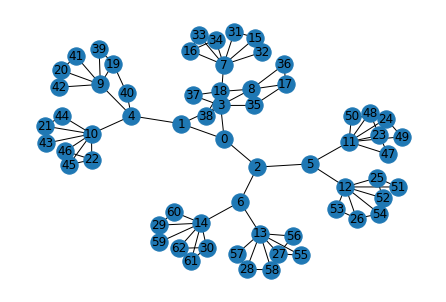

In [227]:
Edges = pd.DataFrame(edges)
id_map = {}
i = 1
names = set( Edges[1] ) | set( Edges[0] ) 
for id in names:
    id_map[id] = str(id).split('N')[1]
    i+=1
id_map
print(id_map)
edgelist = Edges.replace({0 : id_map, 1 : id_map} )
edgelist.columns = ['source','target']

meta = []
for id in names:
    N = str(id).split('N')[1]
    Gen = str(id).split(':')[0].replace('Gen','')
    seq = simulated_dataset[id]
    meta.append([Gen,N, seq])
meta = pd.DataFrame(meta, columns=['Gen','N', 'seq'])
meta


G = nx.Graph()
G = nx.from_pandas_edgelist(edgelist)
nx.draw_kamada_kawai(G, with_labels=True)

In [210]:
# combine edgelist and meta to add date
meta.columns = ['source_gen','source','seq_ref']
conneted_sequences = pd.merge(meta, edgelist)
meta.columns = ['target_gen','target','seq_tar']
conneted_sequences = pd.merge(meta, conneted_sequences)
conneted_sequences['gen_dif'] = abs(conneted_sequences['source_gen'].astype(int) - conneted_sequences['target_gen'].astype(int))
conneted_sequences = conneted_sequences.loc[conneted_sequences.gen_dif != 0,:]
# conneted_sequences
conneted_sequences = conneted_sequences.reset_index()


In [211]:
pair[1]

index                                                        29
target_gen                                                    0
target                                                        0
seq_tar       CCAACTCTAAGTATACTTCAATGCATCTTTTCCAGTTATGTTACTT...
source_gen                                                    1
source                                                        1
seq_ref       CCAACTCTAAGTATACTTCAATGCATCTTTTCCAGTTATGTTACTT...
gen_dif                                                       1
Name: 26, dtype: object

In [212]:
vars_all  = pd.DataFrame()
mut_rate  = []
for pair in conneted_sequences.iterrows() :
    sr = pair[1][3]
    st = pair[1][6]
    alignments = pairwise2.align.globalms(sr, st, 5, -4, -3, -.1)
    alignment = format_alignment(*alignments[0]).split('\n')
    ref_bases = [char for char in alignment[0]] 
    tar_bases = [char for char in alignment[2]] 
    pos = [ i for i in range(len(alignment[2])) ]
    vars = [ref_bases, tar_bases, pos]
    vars = pd.DataFrame(vars).T
    vars.columns = ['ref','tar','pos']
    vars = vars.loc[vars.ref != vars.tar ,:]
    vars.to_csv( "./data/align/" + str( str(pair[1][1]) + str(pair[1][4]) ) )
    vars_all = vars_all.append(vars) 
    mut_rate.append([vars.shape[0] , pair[1][7]])

vars_all.to_csv( './data/simulation_dataset/vars'+'.csv')
mut_rate = pd.DataFrame(mut_rate, columns=['x','y'])
mut_rate.to_csv( './data/simulation_dataset/mut_rate.csv')

/tmp/ipykernel_289680/3980063312.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vars_all = vars_all.append(vars)
/tmp/ipykernel_289680/3980063312.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vars_all = vars_all.append(vars)
/tmp/ipykernel_289680/3980063312.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vars_all = vars_all.append(vars)
/tmp/ipykernel_289680/3980063312.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vars_all = vars_all.append(vars)
/tmp/ipykernel_289680/3980063312.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inst

In [213]:
vars_all.head()

,ref,tar,pos
51,G,A,51
69,C,T,69
509,T,A,509
594,G,A,594
728,T,A,728


(27,) (27,)


57.90909090909091

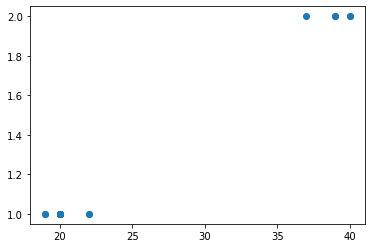

In [214]:
from sklearn import linear_model

# load dataset
x, y = mut_rate.x , mut_rate.y
# summarize shape
print(x.shape, y.shape)
# scatter plot of input vs output
plt.scatter(x, y)



x = np.array(mut_rate[["x"]])
y = np.array(mut_rate[["y"]])


regr = linear_model.LinearRegression()
regr.fit(y, x)
# predictedCO2 = regr.predict([[2300, 1300]])

n_geners = 3
test = np.array([n_geners]).reshape(1, 1)
n_mut_predicted = regr.predict(test)
n_mut_predicted[0][0]


# predict next position (fiting model to vars_all)

In [215]:
import scipy
import numpy as np

# fit to var_1
mu, std = scipy.stats.norm.fit(np.array(vars_all['pos'], dtype=int) )

# generate data for var_2
var_2 = np.random.normal(mu, std, size=1 )
var_2

array([1175.69307262])

# predict next mutation

In [216]:
seq0 = meta.iloc[0,2] # to mutate


In [218]:
Vars_all = vars_all

# One-hot encoding is easy to perform with the scikit-learn preprocessing library. In this code, we will one-hot encode the column stored in the variable column from the dataframe vars_all.
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
#ref
onehotarray = encoder.fit_transform(Vars_all[['ref']]).toarray()
items = [f'ref_{item}' for item in encoder.categories_[0]]
Vars_all[items] = onehotarray
#tar
onehotarray = encoder.fit_transform(Vars_all[['ref']]).toarray()
items = [f'tar_{item}' for item in encoder.categories_[0]]
Vars_all[items] = onehotarray
Vars_all

,ref,tar,pos,ref_-,ref_A,ref_C,ref_G,ref_T,tar_-,tar_A,tar_C,tar_G,tar_T
51,G,A,51,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
69,C,T,69,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
509,T,A,509,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
594,G,A,594,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
728,T,A,728,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1784,G,C,1784,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1831,G,A,1831,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1920,T,A,1920,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1949,T,A,1949,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [204]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X = Vars_all.iloc[:,list(range(2,Vars_all.shape[1]))]
y = Vars_all.tar

randomforest = RandomForestClassifier()
randomforest.fit(X, y)
X_test = pd.DataFrame([['A',100],['A',101],['C',1100],['C',800]])
X_test.columns=['ref','pos']
#####
onehotarray = encoder.fit_transform(X_test[['ref']]).toarray()
items = [f'ref_{item}' for item in encoder.categories_[0]]
X_test[items] = onehotarray
# add missing cols
col = Vars_all.columns
missing_cols = [ c for c in col if c not in X_test.columns and '_' in c ]
X_test[missing_cols] = 0
X_test = X_test[['pos', 'ref_-', 'ref_A', 'ref_C', 'ref_G', 'ref_T']]
####
y_pred = randomforest.predict(X_test)
y_pred

array(['C', 'C', '-', 'A'], dtype=object)